<a href="https://colab.research.google.com/github/sahithinamala/MachineLearning/blob/main/du_unet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import torch
import torch.nn as nn
from collections import OrderedDict

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=4):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [67]:
from torchvision.transforms import Resize,Compose,InterpolationMode,ToTensor
tr = Compose([Resize((512,512),InterpolationMode.BILINEAR),ToTensor()])
tr

Compose(
    Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [68]:
!ls

drive  model_weights.onnx  model_weights.pth  sample_data


In [69]:
import glob
from PIL import Image
from torchvision.transforms.functional import to_tensor

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class HairDataset(Dataset):

    def __init__(self, root_dir, transform=tr):
        
        self.root_dir = root_dir
        self.transform = transform
        self.data = glob.glob(root_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        m = self.data[idx]
        num = int(m.split('/')[-1].split('_')[0])
        img_name =  '/content/drive/MyDrive/train_data/CelebAMask-HQ/CelebA-HQ-img/'+str(num)+'.jpg'
        # img_name = m.replace('masked','')

        image = Image.open(img_name)
        mask = Image.open(m)
        sample = image,mask
        if self.transform:
            sample = self.transform(sample[0]),self.transform(sample[1])

        return sample

In [70]:
# train_folder_path = '/content/drive/MyDrive/train_tiff/'
train_folder_path = '/content/drive/MyDrive/train_data/CelebAMask*/CelebAMask-HQ-mask-anno/*/*_hair.png'
dataset = HairDataset(train_folder_path)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

In [71]:
for d in dataloader:
  print(d[0].shape,d[1].shape)
  break

torch.Size([8, 3, 512, 512]) torch.Size([8, 3, 512, 512])


In [72]:
import torch 
import numpy as np
model = UNet().cuda()
criteria = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([8, 1, 512, 512])) that is different to the input size (torch.Size([8, 3, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0  Batch: 0 Batch_Loss 0.2657005786895752
Epoch: 0  Batch: 1 Batch_Loss 0.22097395360469818
Epoch: 0  Batch: 2 Batch_Loss 0.22041663527488708
Epoch: 0  Batch: 3 Batch_Loss 0.220100998878479
Epoch: 0  Batch: 4 Batch_Loss 0.17650626599788666
Epoch: 0  Batch: 5 Batch_Loss 0.1836150586605072
Epoch: 0  Batch: 6 Batch_Loss 0.22655247151851654
Epoch: 0  Batch: 7 Batch_Loss 0.17989441752433777
Epoch: 0  Batch: 8 Batch_Loss 0.17499123513698578
Epoch: 0  Batch: 9 Batch_Loss 0.19433164596557617
Epoch: 0  Batch: 10 Batch_Loss 0.21077129244804382
Epoch: 0  Batch: 11 Batch_Loss 0.17875485122203827
Epoch: 0  Batch: 12 Batch_Loss 0.20729725062847137
Epoch: 0  Batch: 13 Batch_Loss 0.17189878225326538
Epoch: 0  Batch: 14 Batch_Loss 0.19738315045833588
Epoch: 0  Batch: 15 Batch_Loss 0.1753339022397995
Epoch: 0  Batch: 16 Batch_Loss 0.1892431229352951
Epoch: 0  Batch: 17 Batch_Loss 0.20387504994869232
Epoch: 0  Batch: 18 Batch_Loss 0.17046141624450684
Epoch: 0  Batch: 19 Batch_Loss 0.17652508616447

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2, 1, 512, 512])) that is different to the input size (torch.Size([2, 3, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
Epoch: 14  Batch: 646 Batch_Loss 0.025158843025565147
Epoch: 14  Batch: 647 Batch_Loss 0.02592414617538452
Epoch: 14  Batch: 648 Batch_Loss 0.023186329752206802
Epoch: 14  Batch: 649 Batch_Loss 0.03223176673054695
Epoch: 14  Batch: 650 Batch_Loss 0.020178519189357758
Epoch: 14  Batch: 651 Batch_Loss 0.021383067592978477
Epoch: 14  Batch: 652 Batch_Loss 0.03860975056886673
Epoch: 14  Batch: 653 Batch_Loss 0.024313947185873985
Epoch: 14  Batch: 654 Batch_Loss 0.03222763538360596
Epoch: 14  Batch: 655 Batch_Loss 0.04525022208690643
Epoch: 14  Batch: 656 Batch_Loss 0.04243289679288864
Epoch: 14  Batch: 657 Batch_Loss 0.03155443072319031
Epoch: 14  Batch: 658 Batch_Loss 0.019631363451480865
Epoch: 14  Batch: 659 Batch_Loss 0.025358762592077255
Epoch: 14  Batch: 660 Batch_Loss 0.033525820821523666
Epoch: 14  Batch: 661 Batch_Loss 0.020340673625469208
Epoch: 14  Batch: 662 Batch_Loss 0.020921118557453156
Epoch: 14  Batch: 663 Batch_Loss 0.032

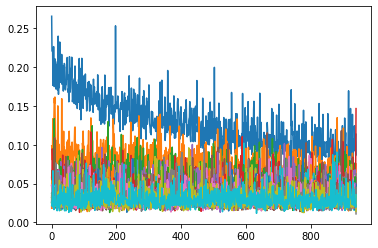

In [73]:
from matplotlib import pyplot as plt
EPOCHS = 20
model = model.cuda()
model.train()
losses = []
for epoch in range(EPOCHS):
  l = []
  for i,(x,y) in enumerate(dataloader):
    x = x.cuda()
    y = y.cuda()
    y_pred = model(x)

    optimizer.zero_grad()
    loss = criteria(y,y_pred)
    loss.backward()
    optimizer.step()
    
    l.append(loss.item())
    del x,y,y_pred
    print('Epoch:',epoch,' Batch:',i,'Batch_Loss',l[-1])
    # plt.plot(l)
  plt.plot(l)

  # plt.plot(l)
  av = np.mean(l)
  print('Epoch:',epoch,'-'*8,'Epoch_Loss:',av)
  losses.append(av)
  



In [74]:
# data = HairDataset('/content/drive/MyDrive/Train_Images/0.tif')
# np.shape(data)

Test on an image

In [75]:


x = Image.open('/content/drive/MyDrive/Test_Images/6.tif')
m = Image.open('/content/drive/MyDrive/Test_Masks/6_mask.tif')


In [76]:

t = to_tensor(x).unsqueeze(0).cuda()
model.eval()
out = model(t)

In [77]:
out_im = out.detach().cpu().squeeze().numpy()

In [78]:
out_im.shape

(1024, 1024)

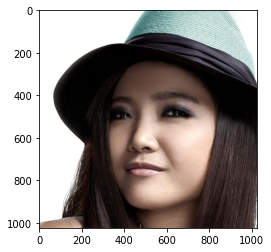

In [79]:
import matplotlib.pyplot as plt
plt.imshow(x)

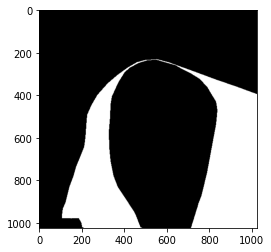

In [80]:

plt.imshow(m)

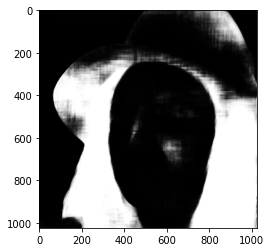

In [81]:

plt.imshow(out_im,'gray')

In [82]:

torch.save(model.state_dict(), 'model_weights.pth')

In [83]:

!pip install onnx
!pip install tensorflow
!pip install tensorflow-addons


In [84]:
!git clone https://github.com/onnx/onnx-tensorflow.git
%cd onnx-tensorflow
!pip install -e .

Cloning into 'onnx-tensorflow'...
remote: Enumerating objects: 6345, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 6345 (delta 192), reused 235 (delta 156), pack-reused 6051
Receiving objects: 100% (6345/6345), 1.97 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (4917/4917), done.
/content/onnx-tensorflow
Obtaining file:///content/onnx-tensorflow
  Attempting uninstall: onnx-tf
    Found existing installation: onnx-tf 1.9.0
    Uninstalling onnx-tf-1.9.0:
      Successfully uninstalled onnx-tf-1.9.0
  Running setup.py develop for onnx-tf


In [85]:

!pip install onnx-tf

In [86]:

import onnx
from onnx_tf.backend import prepare

In [87]:
trained_model = UNet()
trained_model.load_state_dict(torch.load('/content/model_weights.pth'))
inp = torch.autograd.Variable(torch.randn(1, 3, 1024, 1024))
torch.onnx.export(trained_model, inp, "/content/model_weights.onnx")

In [88]:
model = onnx.load('/content/model_weights.onnx')
tf_rep = prepare(model) 

In [35]:
!ls /content/*.onnx

/content/model_weights.onnx


In [91]:
img = Image.open('/content/drive/MyDrive/Train_Images/4.tif')
inp = np.asarray(img, dtype=np.float32).transpose(2,0,1)[np.newaxis, :, :, :]
out = tf_rep.run(inp)


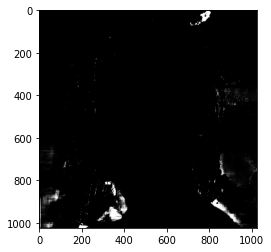

In [92]:
plt.imshow(out[0][0][0],'gray')

In [93]:
from torch.autograd import Variable

In [94]:
trained_model = UNet()
trained_model.load_state_dict(torch.load('/content/model_weights.pth'))

dummy_input = Variable(torch.randn(1, 3, 1024, 1024)) 
torch.onnx.export(trained_model, dummy_input, "/content/model_weights.onnx")

In [95]:
model = onnx.load('/content/model_weights.onnx')
tf_rep = prepare(model)

In [96]:
print('inputs:', tf_rep.inputs)

# Output nodes from the model
print('outputs:', tf_rep.outputs)

# All nodes in the model
print('tensor_dict:')
print(tf_rep.tensor_dict)

inputs: ['input.1']
outputs: ['186']
tensor_dict:
{}


In [97]:
tf_rep.export_graph('/content/drive/MyDrive/model_new2.pb')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_new2.pb/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_new2.pb/assets


In [98]:
import tensorflow as tf

In [99]:

!pip install onnx2keras

In [103]:

import onnx
from onnx2keras import onnx_to_keras
onnx_model = onnx.load('/content/model_weights.onnx')
keras_model = onnx_to_keras(onnx_model,['input.1'])


In [104]:
keras_model.predict(inp)

array([[[[6.2513629e-07, 2.1885746e-12, 3.5828613e-14, ...,
          1.6058417e-15, 2.3443683e-16, 7.2893087e-14],
         [3.9968532e-07, 2.5557751e-13, 2.7354947e-17, ...,
          6.0378663e-21, 6.6236198e-19, 2.1363056e-17],
         [4.1975756e-08, 2.2083210e-15, 6.4192666e-20, ...,
          1.9600052e-22, 9.2915802e-19, 2.0464465e-18],
         ...,
         [3.3388078e-02, 7.7068517e-03, 8.0124363e-03, ...,
          1.7487605e-03, 1.3935753e-03, 3.1445066e-03],
         [3.3823878e-02, 1.6843943e-02, 1.8979928e-02, ...,
          2.2280640e-03, 3.8192896e-03, 5.5621760e-03],
         [2.2704136e-01, 7.9234116e-02, 8.3702214e-02, ...,
          3.2575421e-02, 4.5422021e-02, 8.1939409e-03]]]], dtype=float32)

In [105]:
!ls '/content/drive/MyDrive/model_new12.pb' -l

ls: cannot access '/content/drive/MyDrive/model_new12.pb': No such file or directory


In [106]:
keras_model

In [108]:
keras_model.save('/content/drive/MyDrive/model_new2.pb')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_new2.pb/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_new2.pb/assets


In [109]:
model_load = tf.keras.models.load_model("/content/drive/MyDrive/model_new2.pb",compile = True)

In [110]:
tf.keras.models.save_model

<function keras.saving.save.save_model>